# Developing a Training Set for Predicting Workplace Air Concentrations
**Author:** Jacob Kvasnicka <br>
**Date:** November 21, 2024

## Background
We are developing a high-throughput modeling framework to predict a chemical's Margin of Exposure (MOE) by integrating:
1. **QSAR Model**:
   - Predicts human-equivalent Points of Departure (POD)
2. **Machine Learning Exposure Model**:
   - Predicts exposure concentrations in U.S. workplaces

![Integrated Modeling Framework](modeling_framework.png)

We observed that the POD model demonstrated sufficient performance:
- Typical prediction error within a factor of 5 mg/m³
- Approximately 50% of the variance explained
    
Based on these results, we shifted our primary focus to developing the exposure model.This notebook focuses ons preparing a training set:
- **Features**: Represent chemical and industry-specific (exposure context) information.
- **Target Variable**: Represents an exposure concentration that is directly comparable to the POD

---

## Datasets
We are using two OSHA datasets, collectively comprising the largest database of industrial hygiene air measurements in North America:

1. **Chemical Exposure Health Data (CEHD)**:
   - Publicly available through OSHA’s website.

2. **United States Information System (USIS)**
   - *Not* publicly available through OSHA's website.
    - Released by Prof. Jérôme Lavoué’s research group at the University of Montreal via multiple FOIA requests. The group published a stable version on GitHub in September 2024 ([https://github.com/UofMontreal-Multiexpo/uom.usis](https://github.com/UofMontreal-Multiexpo/uom.usis)).

---

## Notebook Organization
This notebook is organized into three main sections:
1. **Overview of Raw Datasets**:
   - Highlightss commonalities and differences between CEHD and USIS datasets.
2. **Data Cleaning Pipelines**:
   - Summarizes the workflows for preparing cleaned CEHD and USIS datasets for machine learning.
3. **Training Set Preparation**:
   - Describess the steps for deriving a representative target variable and features for the exposure model.

In [1]:
import pandas as pd
import numpy as np
import random
import json

from config_management import UnifiedConfiguration
from raw_processing import (
    cehd_loading,     
    cehd_cleaning, 
    usis_cleaning, 
    cehd_processing, 
    usis_processing,
    osha_processing
)
from raw_processing.tests import (
    test_cehd, 
    test_usis
)

import data_management
import plot

config = UnifiedConfiguration()

## 1. Overview of Raw Datasets

While there is overlap in the OSHA measurements contained within the CEHD and USIS datasets, important differences exist, as summarized below.

### **USIS (United States Information System)**
- Aggregates two datasets: The legacy **Integrated Management Information System (IMIS)** (1971–2015) and its next-generation replacement, **OSHA Information System (OIS)** (2011–2021).
- **IMIS** was established in 1972 as a data-entry and retrieval system for OSHA enforcement activities at both federal and State levels.
    - OSHA inspectors were responsible for:
      - Documenting outcomes of inspections.
      - Entering exposure measurement data into IMIS.
    - Each record includes:
        - Company information.
        - Free-text job descriptions of the monitored worker.
        - Other inspection and measurement characteristics.
- **OIS** expands beyond enforcement to encompass all OSHA programs and regulatory practices.

### **CEHD (Chemical Exposure Health Data)**
- Includes all OSHA measurements analyzed by the Salt Lake Technical Center from 1984 through the latest dataset (2023 release).
- Includes primarily federal OSHA samples and some State samples
- Samples were collected by inspectors during compliance assessments
- Inspectors calculated Time-weighted averages (TWAs) and recorded in USIS.

![Conceptual Linkage](concept_figure.png)

In [2]:
cehd_cleaner = cehd_cleaning.CehdCleaner(config.cehd, config.path)
usis_cleaner = usis_cleaning.UsisCleaner(config.usis, config.path)

In [3]:
raw_cehd = cehd_cleaner.load_raw_data()
raw_usis = usis_cleaner.load_raw_data()

In [30]:
raw_cehd

,AIR_VOLUME_SAMPLED,BLANK_USED,CITY,DATE_REPORTED,DATE_SAMPLED,EIGHT_HOUR_TWA_CALC,ESTABLISHMENT_NAME,FIELD_NUMBER,IMIS_SUBSTANCE_CODE,INSPECTION_NUMBER,...,SAMPLE_TYPE,SAMPLE_WEIGHT,SAMPLING_NUMBER,SIC_CODE,STATE,SUBSTANCE,TIME_SAMPLED,UNIT_OF_MEASUREMENT,YEAR,ZIP_CODE
index,,,,,,,,,,,,,,,,,,,,,
0,516.00,N,Plainview,1984-06-15,1984-05-07,None,CONTROLLED CASTINGS CORP,2LI8491,T100,111211,...,P,NaN,5245543,3365,NY,Thorium,258.0,M,1984,11803
1,NaN,Y,Plainview,1984-06-15,1984-05-07,None,CONTROLLED CASTINGS CORP,2LI8492,T100,111211,...,P,NaN,5245543,3365,NY,Thorium,NaN,None,1984,11803
2,76.00,N,Plainview,1984-06-15,1984-05-07,None,CONTROLLED CASTINGS CORP,2LI8493,T100,111211,...,P,NaN,5245501,3365,NY,Thorium,38.0,M,1984,11803
3,NaN,Y,Plainview,1984-06-15,1984-05-07,None,CONTROLLED CASTINGS CORP,2LI8494,T100,111211,...,P,NaN,5245501,3365,NY,Thorium,NaN,None,1984,11803
4,74.00,N,East Farmingdale,1984-04-27,1984-04-04,None,MID ISLAND NON FERROUS FOUNDRY,2LI84-49,1591,111252,...,P,0.0,5245345,3365,NY,"Lead, Inorganic (as Pb)",37.0,M,1984,11735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2604832,NaN,N,SHENANDOAH,2024-03-04,2023-11-30,N,Accura HealthCare of Shenandoah,B1130MS23,C730,1714760,...,P,NaN,912794476,None,IA,Carbon Monoxide (by COHb),NaN,P,2023,51601
2604833,NaN,N,SHENANDOAH,2024-03-04,2023-11-30,N,Accura HealthCare of Shenandoah,A1130MS23,C730,1714760,...,P,NaN,912794468,None,IA,Carbon Monoxide (by COHb),NaN,P,2023,51601
2604834,NaN,N,KUNA,2024-04-04,2023-12-08,N,"Alta Construction, Inc.",1,S777,1715324,...,B,NaN,442864,None,ID,Soil,NaN,N,2023,83634


CEHD data *not* recorded in USIS:
- Sampling duration (TIME_SAMPLED)
- Analytical method (INSTRUMENT_TYPE)

In [32]:
raw_usis

,inspection_id,inspection_number,original_db,inspection_type_id,inspection_type_name,scope_id,scope_name,was_notified,is_unionized,number_of_covered,...,substance_name,is_detected,exposure_level,measure_unit_id,measure_unit_name,exposure_type_id,exposure_type_name,oel,severity,year
0,1,117919878,IMIS,B,Complaint,B,Partial,False,False,NaN,...,Styrene,True,51.9255,P,Part per million,T,Full Shift Time Weighted Average (TWA),100.000,0.519255,2006
1,1,117919878,IMIS,B,Complaint,B,Partial,False,False,NaN,...,Styrene,True,28.8542,P,Part per million,T,Full Shift Time Weighted Average (TWA),100.000,0.288542,2006
2,1,117919878,IMIS,B,Complaint,B,Partial,False,False,NaN,...,Styrene,True,31.0451,P,Part per million,T,Full Shift Time Weighted Average (TWA),100.000,0.310451,2006
3,2,112519533,IMIS,H,Program Planned,B,Partial,False,False,NaN,...,Methylene bisphenyl isocyanate,True,0.3327,M,Milligrams per cubic meter,C,Ceiling,0.200,1.663500,2006
4,3,112520028,IMIS,B,Complaint,B,Partial,False,False,NaN,...,Manganese Fume (as Mn),True,0.2200,M,Milligrams per cubic meter,C,Ceiling,5.000,0.044000,2007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
765332,94247,1543658,OIS,B,Complaint,B,Partial,None,False,NaN,...,"Molydbenum (as Mo), Insoluble Compounds (Total...",False,0.0000,NaN,None,T,Full Shift Time Weighted Average (TWA),15.000,0.000000,2021
765333,94247,1543658,OIS,B,Complaint,B,Partial,None,False,NaN,...,"Nickel, Metal and Insoluble compounds (as Ni)",False,0.0000,NaN,None,T,Full Shift Time Weighted Average (TWA),1.000,0.000000,2021
765334,94247,1543658,OIS,B,Complaint,B,Partial,None,False,NaN,...,CADMIUM,False,0.0000,NaN,None,T,Full Shift Time Weighted Average (TWA),0.005,0.000000,2021
765335,94247,1543658,OIS,B,Complaint,B,Partial,None,False,NaN,...,Vanadium,False,0.0000,NaN,None,T,Full Shift Time Weighted Average (TWA),0.000,0.000000,2021


In [26]:
percent_IMIS = round(sum((raw_usis['original_db'] == 'IMIS')/len(raw_usis))*100)
print(f'{percent_IMIS}% of USIS samples are IMIS')

81% of USIS samples are IMIS


In [55]:
# Proportion of samples for each inspection type
(raw_usis['inspection_type_name'].value_counts()/len(raw_usis)).round(2)

Complaint                       0.50
Program Planned                 0.26
Referral                        0.14
Follow-Up                       0.04
Other -- ATARs                  0.02
Unprogrammed Related            0.02
Monitoring                      0.01
Unprogrammed Other              0.01
Programmed Related              0.01
Accident                        0.00
Referral - Employer Reported    0.00
Programmed Other                0.00
Other -- Other                  0.00
Fatality/Catastrophe            0.00
Variance                        0.00
Name: inspection_type_name, dtype: float64

In [46]:
# Show the first 15 unique occupation titles
raw_usis['occ_name'].unique()[:15]

array(['N/A (not applicable)',
       'Administrators and officials, public administration',
       'Janitors and cleaners', 'Social workers',
       'Carpenters, except apprentices', 'Supervisors, general office',
       'Managers and administrators, n.e.c.', 'Construction inspectors',
       'Secretaries', 'Chemical technicians',
       'Chemists, except biochemists', 'Trade and industrial teachers',
       'Engineers, n.e.c.', 'Correctional institution officers',
       'Administrative support occupations, n.e.c.'], dtype=object)

In [47]:
# Show the first 15 unique job titles
raw_usis['job_title'].unique()[:15]

array(['GEL COATING', 'FIBERGLASSING', 'SPRAY PAINTER', 'WELDING',
       'SOLE-LAY ASSEMBLY', 'SANIRATER', 'WELDER', 'FURNACE OPERATOR',
       'MOLDER', 'WHEELABRATOR AREA', 'BLASTER/PAINTER', 'BLASTER',
       'BURNOUT', 'X', 'BURNER'], dtype=object)

### Hierarchical Structure of OSHA Measurement Data

The OSHA data are organized hierarchically as follows:

1. **Sampling Number**:
   - Unique identifier tied to the Air Sampling Worksheet (OSHA 91A).
   - Represents an individual “evaluation” for a worker (e.g., a worker’s full shift).
   - Provides a link between the USIS and CEHD datasets.
   - In CEHD:
     - Multiple samples for a given chemical and sampling number correspond to partial-shift measurements.
     - OSHA inspectors will aggregate these measurements into a TWA before recording in USIS.

2. **Inspection Number**:
   - Unique identifier for each OSHA inspection of a specific workplace.
   - May involve several workers, and therefore several sampling numbers.

3. **Industry Classification**:
   - Represented by:
     - Four-digit **Standard Industrial Classification (SIC)** codes (1972 or 1987).
     - Six-digit **North American Industry Classification System (NAICS)** codes (introduced after 1997).

## 2. Data Cleaning Pipelines

To ensure consistent, high-quality data for modeling across both CEHD and USIS datasets, I implemented a dual-pipeline approach. This approach is adaptable to future updates, expansions, or other projects such as data curation.

### CEHD Data Cleaning Pipeline
- **Original Pipeline**:
  - Developed in R by Prof. Jérôme Lavoué and colleagues at the University of Montreal.
- **Python Translation**:
  - I translated the original pipeline into Python for incorporation within our project.
  - Designed for flexibility:
    - Extensible to datasets beyond 2018.
    - Incorporates additional cleaning steps (e.g., convert to mass concentration, convert substance names to DTXSIDs)
    - Highly modular where cleaning steps can easily be added, removed, rearranged, or augmented

### USIS Data Cleaning Pipeline
- Unlike CEHD, the USIS dataset lacked prior cleaning.
- Developed a new cleaning pipeline:
  - Incorporates similar cleaning logic to CEHD where applicable.
  - Accomodates the unique dataset structure and content

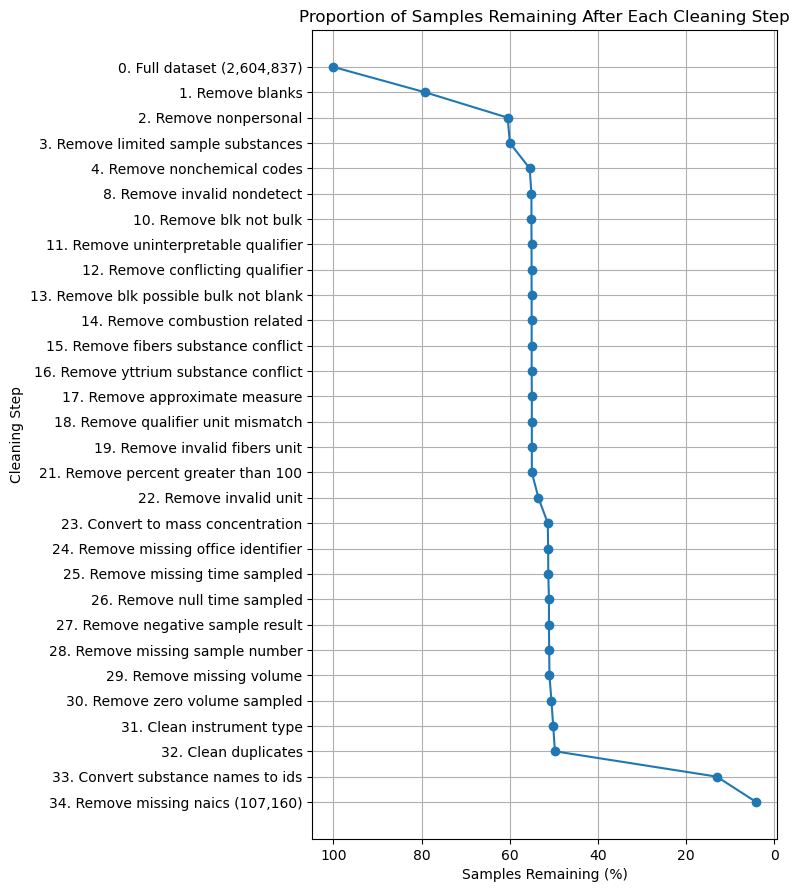

In [3]:
# NOTE: We might not need all these cleaning step
cehd_initial_count = len(raw_cehd)

_ = plot.cumulative_changes(
    config.path['cehd_log_file'], 
    cehd_initial_count
)

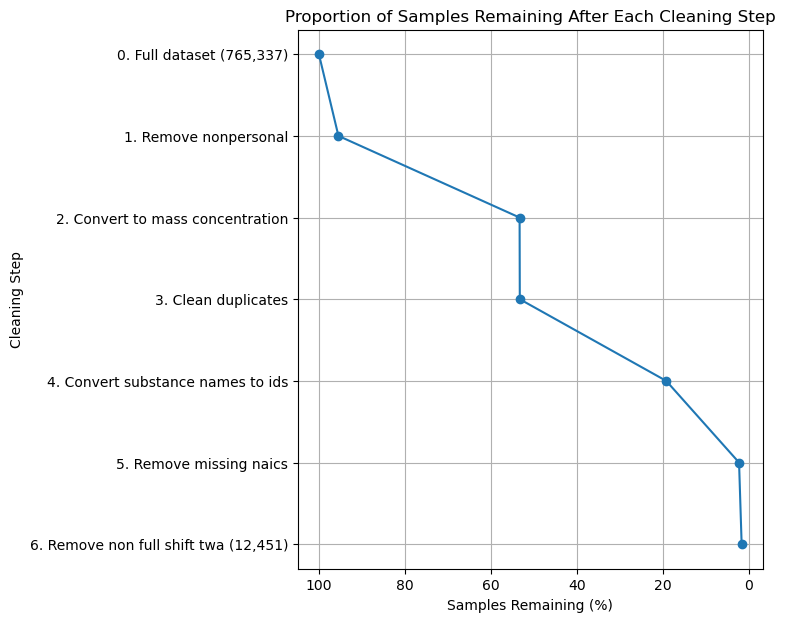

In [4]:
usis_initial_count = len(raw_usis)

_ = plot.cumulative_changes(
    config.path['usis_log_file'], 
    usis_initial_count
)

## 3. Training Set Preparation

The target variable in our modeling framework must be directly comparable to the POD for calculating a Margin of Exposure (MOE) for risk-based screening. Fortunately, the POD predictions:
- Are expressed in air concentration units [mg/m³].
- Were derived from chronic studies and adjusted from animals to humans using a "Dosimetric Adjustment Factor."
- Were "calibrated" to regulatory/authoritative PODs which were adjusted to a consistent continuous exposure pattern. 
  - Example: A POD of 100 ppm @ 6 hr/day, 5 days/week would have been converted to $100 \times (6/24) \times (5/7)$ ppm continuous exposure.

Thus, the standard risk assessment approach is to directly compare the POD in concentration units with a continuous personal air concentration to derive a MOE. This streamlined approach enables us to model OSHA air concentration data directly, eliminating the need for additional models like ChemSTEER, resulting in a more parsimonious and high-throughput framework.

---

### Steps for Deriving the Target Variable

Our primary modeling task is to predict a representative personal exposure concentration, adjusted for continuous exposure, for a given chemical and industry (NAICS). The only model inputs would be the chemical's DTXSID and the NAICS code for the industry being evaluated.

#### Step 1: Restrict to Full-Shift TWA Concentrations
- **USIS Data**:
  - Excluded several sample types including peak exposures, short-term exposure limits, and ceiling limits.
- **CEHD Data**:
  - Treated multiple records tied to a single sampling number and chemical as sequential partial-shift measurements.
  - Aggregated these measurements to calculate total sampling time and a TWA concentration, following the approach of Sarazin et al. (2018).
 
**Reference:** *Sarazin, P., Burstyn, I., Kincl, L., Friesen, M. C., & Lavoué, J. (2018). Characterization of the selective recording of workplace exposure measurements into OSHA’s IMIS Databank. Annals of work exposures and health, 62(3), 269-280.*

---

#### Step 2: Convert TWAs to Continuous Equivalents
Given the intermittant nature of a typical work schedule, I converted full-shift TWAs into continuous-equivalent concentrations based on EPA Risk Assessment Guidance for Superfund (2009). 

##### Equation 1:
$$
EC = \frac{CA \times ET \times EF \times ED}{AT}
$$
Where:
- **CA**: Air concentration (mg/m³) [in this case, measured by OSHA]
- **ET**: Exposure time (hours/day)
- **EF**: Exposure frequency (days/year)
- **ED**: Exposure duration (years)
- **AT**: Averaging time, calculated as $ED \times 365 (days/year) \times 24 (hours/day)$

**Assumed Parameters (Typical Work Schedule)**:
- ET = 8 hours/day
- EF = 250 days/year
- ED = 25 years

**Reference:** *United States Environmental Protection Agency (2009). Risk assessment guidance for superfund: Volume I: Human health evaluation manual (Part F, supplemental guidance for inhalation risk assessment) (EPA-540-R-070-002; OSWER 9285.7-82). Office of Superfund Remediation and Technology Innovation.*

---

#### Step 3: Aggregate Measurement Data
To ensure each training set sample represents a typical exposure for a given chemical and industry (NAICS), the following aggregation workflow was applied:

1. **Inspection-Level Aggregation**:
   - Calculated the *median exposure concentration* across sampling numbers (workers) within each inspection.
   - Resulting value represents the *typical exposure for a worker* in the inspected workplace.
   
2. **Industry-Level Aggregation**:
   - Calculated the *median exposure concentration* across all inspections for a given industry (NAICS).
   - The resulting value represents the *typical exposure for a chemical in a specific industry*.
   - I designed the code to enable sensitivity analyses comparing different industry representations, e.g., sector versus subsector.

In [4]:
root_dir = 'input/processed/target'
# Read all target data to a dict
target_for = data_management.read_targets(root_dir)

opera_features = pd.read_parquet(config.path['opera_features_file'])

In [11]:
target_for[('cehd', 'sector')]

DTXSID         NAICS_CODE
DTXSID0020600  31            0.024987
               32            0.000000
               33            0.042973
               42            0.049871
               54            0.000000
                               ...   
DTXSID9049617  42            0.000000
               48            0.000000
               54            0.000000
               81            0.000000
               92            0.000000
Name: mg_per_m3, Length: 1364, dtype: float64

In [8]:
target_for[('usis', 'industry_group')]

DTXSID           naics_id
DTXSID001316703  3331         0.001301
DTXSID0020573    4461         0.013470
DTXSID0020604    3323         0.410959
DTXSID0020868    2362        10.516027
                 2383        45.601171
                               ...    
DTXSID9049748    3329         0.004909
DTXSID9050484    3315         0.002397
                 3329         0.006735
DTXSID9051660    8113         0.006164
DTXSID9058789    3323         0.015297
Name: mg_per_m3, Length: 2577, dtype: float64

In [10]:
data_management.naics_features_from_target(target_for[('cehd', 'sector')])

11  21  22  23  31  32  33  42  44  45  ...  53  54  \
DTXSID        NAICS_CODE                                          ...           
DTXSID0020600 31           0   0   0   0   1   0   0   0   0   0  ...   0   0   
              32           0   0   0   0   0   1   0   0   0   0  ...   0   0   
              33           0   0   0   0   0   0   1   0   0   0  ...   0   0   
              42           0   0   0   0   0   0   0   1   0   0  ...   0   0   
              54           0   0   0   0   0   0   0   0   0   0  ...   0   1   
...                       ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..   
DTXSID9049617 42           0   0   0   0   0   0   0   1   0   0  ...   0   0   
              48           0   0   0   0   0   0   0   0   0   0  ...   0   0   
              54           0   0   0   0   0   0   0   0   0   0  ...   0   1   
              81           0   0   0   0   0   0   0   0   0   0  ...   0   0   
              92           0   0   0   0   0   0   0   0   0   0  ...   0   0   

                          55  56  61  62  71  72  81  92  
DTXSID        NAICS_CODE                                  
DTXSID0020600 31           0   0   0   0   0   0   0   0  
              32           0   0   0   0   0   0   0   0  
              33           0   0   0   0   0   0   0   0  
              42           0   0   0   0   0   0   0   0  
              54           0   0   0   0   0   0   0   0  
...                       ..  ..  ..  ..  ..  ..  ..  ..  
DTXSID9049617 42           0   0   0   0   0   0   0   0  
              48           0   0   0   0   0   0   0   0  
              54           0   0   0   0   0   0   0   0  
              81           0   0   0   0   0   0   1   0  
              92           0   0   0   0   0   0   0   1  

[1364 rows x 24 columns]

In [12]:
data_management.read_features(config.path['opera_features_file'], y=target_for[('cehd', 'sector')])

11  21  22  23  31  32  33  42  44  45  ...  \
DTXSID        NAICS_CODE                                          ...   
DTXSID0020600 31           0   0   0   0   1   0   0   0   0   0  ...   
              32           0   0   0   0   0   1   0   0   0   0  ...   
              33           0   0   0   0   0   0   1   0   0   0  ...   
              42           0   0   0   0   0   0   0   1   0   0  ...   
              54           0   0   0   0   0   0   0   0   0   0  ...   
...                       ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...   
DTXSID9024148 92           0   0   0   0   0   0   0   0   0   0  ...   
DTXSID9024691 23           0   0   0   1   0   0   0   0   0   0  ...   
              32           0   0   0   0   0   1   0   0   0   0  ...   
              33           0   0   0   0   0   0   1   0   0   0  ...   
              44           0   0   0   0   0   0   0   0   1   0  ...   

                          Sp3Sp2HybRatio  nbRotBd_discrete  nbHBdAcc_discrete  \
DTXSID        NAICS_CODE                                                        
DTXSID0020600 31                     1.0               0.0                1.0   
              32                     1.0               0.0                1.0   
              33                     1.0               0.0                1.0   
              42                     1.0               0.0                1.0   
              54                     1.0               0.0                1.0   
...                                  ...               ...                ...   
DTXSID9024148 92                     NaN               0.0                1.0   
DTXSID9024691 23                     1.0               5.0                2.0   
              32                     1.0               5.0                2.0   
              33                     1.0               5.0                2.0   
              44                     1.0               5.0                2.0   

                          ndHBdDon_discrete  nbLipinskiFailures_discrete  \
DTXSID        NAICS_CODE                                                   
DTXSID0020600 31                        0.0                          0.0   
              32                        0.0                          0.0   
              33                        0.0                          0.0   
              42                        0.0                          0.0   
              54                        0.0                          0.0   
...                                     ...                          ...   
DTXSID9024148 92                        0.0                          0.0   
DTXSID9024691 23                        0.0                          0.0   
              32                        0.0                          0.0   
              33                        0.0                          0.0   
              44                        0.0                          0.0   

                          TopoPolSurfAir  MolarRefract  CombDipolPolariz  \
DTXSID        NAICS_CODE                                                   
DTXSID0020600 31                   12.53       11.0435             0.462   
              32                   12.53       11.0435             0.462   
              33                   12.53       11.0435             0.462   
              42                   12.53       11.0435             0.462   
              54                   12.53       11.0435             0.462   
...                                  ...           ...               ...   
DTXSID9024148 92                   23.79        7.0145             0.311   
DTXSID9024691 23                   21.76       32.4946             0.608   
              32                   21.76       32.4946             0.608   
              33                   21.76       32.4946             0.608   
              44                   21.76       32.4946             0.608   

                              VP_pred    WS_

In [5]:
for k, y in target_for.items():
    print(k[0].upper(), k[-1])

    # Filter out chemicals that didn't pass the QSAR-ready workflow
    y, _ = y.align(opera_features, join='inner')

    N_samples = len(y)
    percent_nondetect = sum(y==0.)/len(y) * 100
    naics_per_chem = y.groupby(level='DTXSID').size()

    print(f'\tN samples: {N_samples}')
    print(f'\t% nondetect: {round(percent_nondetect)}')
    print(f'\tMedian NAICS per chemical: {int(naics_per_chem.min())}')
    print(f'\tMedian NAICS per chemical: {int(naics_per_chem.median())}')
    print(f'\tMaximum NAICS per chemical: {int(naics_per_chem.max())}')

CEHD industry_group
	N samples: 3346
	% nondetect: 46
	Median NAICS per chemical: 1
	Median NAICS per chemical: 12
	Maximum NAICS per chemical: 153
CEHD sector
	N samples: 988
	% nondetect: 53
	Median NAICS per chemical: 1
	Median NAICS per chemical: 5
	Maximum NAICS per chemical: 22
CEHD subsector
	N samples: 2008
	% nondetect: 50
	Median NAICS per chemical: 1
	Median NAICS per chemical: 10
	Maximum NAICS per chemical: 67
USIS industry_group
	N samples: 1852
	% nondetect: 0
	Median NAICS per chemical: 1
	Median NAICS per chemical: 2
	Maximum NAICS per chemical: 106
USIS sector
	N samples: 655
	% nondetect: 0
	Median NAICS per chemical: 1
	Median NAICS per chemical: 2
	Maximum NAICS per chemical: 20
USIS subsector
	N samples: 1173
	% nondetect: 0
	Median NAICS per chemical: 1
	Median NAICS per chemical: 2
	Maximum NAICS per chemical: 45


In [6]:
cehd_chemicals = target_for[('cehd', 'sector')].index.unique(level='DTXSID')
usis_chemicals = target_for[('usis', 'sector')].index.unique(level='DTXSID')

print(f'{len(cehd_chemicals.union(usis_chemicals))} chemicals in the union of CEHD & USIS')

print(f'{len(cehd_chemicals.intersection(usis_chemicals))} chemicals in both datasets')

print(f'{len(cehd_chemicals.difference(usis_chemicals))} unique to CEHD')

print(f'{len(usis_chemicals.difference(cehd_chemicals))} unique to USIS')

279 chemicals in the union of CEHD & USIS
143 chemicals in both datasets
39 unique to CEHD
97 unique to USIS


## Next Steps
1. Combine the CEHD and USIS datasets (union) to maximize chemical coverage
2. Reserve 10% of the chemicals as a held-out validation set
3. Train a suite of machine learning (regression) models on the remaining 90% and select the best model
4. Evaluate the final model's generalization error on the validation set